In [16]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

In [17]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp
import git

In [18]:
os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"

In [19]:
from collections import defaultdict
import time
import json

In [20]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal
from labellines import labelLine, labelLines


In [21]:
from spectral_connectivity import Multitaper, Connectivity

In [22]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [23]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [24]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [25]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [26]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [27]:
import spikeinterface.full as si

In [28]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

- Getting the root directory of the Github Repo to base the files off of

In [29]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [30]:
git_root

'/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls'

- Getting a list of all the electrophysiological recording files
    - **NOTE**: If your recording file does not end with `.rec` or is in a different directory than `./data` then you must change `glob.glob({./path/to/recording_file.rec})` below. Where you replace `{./path/to/recording_file.rec}` with the path to your recording file without the brackets.

```
MD EIB: 0(1 on Nancy notebook) Spike Gadgets/Spike Interface: 0
vHPC EIB: 16(17 on Nancy notebook) Spike Gadgets/Spike Interface: 31
BLA EIB: 17(18 on Nancy notebook) Spike Gadgets/Spike Interface: 30
LH EIB: 18(19 on Nancy notebook) Spike Gadgets/Spike Interface: 29
```

In [31]:
brain_region_to_channel = {"mPFC": "21", "MD": "16", "vHPC": "15", "BLA": "14", "LH": "13"}

In [32]:
brain_region_to_channel = {k: v for k, v in sorted(brain_region_to_channel.items(), key=lambda item: item[1])}

In [33]:
brain_region_to_channel.keys()

dict_keys(['LH', 'BLA', 'vHPC', 'MD', 'mPFC'])

In [34]:
brain_region_to_channel.values()

dict_values(['13', '14', '15', '16', '21'])

In [43]:
all_regions = brain_region_to_channel.keys()

In [44]:
channel_ids = brain_region_to_channel.values()
time_range=(1000, 1005)
resampled_frequency = 1000

In [45]:
time_halfbandwidth_product=10

### Brain Region to Channel

```
- All Trodes
    - 21, 31, 15, 14, 13
- mPFC:
    - 21 (0 to 31 on Spike interface)
    - 22(1 to 32 on Trodes)
- MD
    - 1 (EIB)
        - Maybe actually 16
    - 31(0 to 31 Spike interface)
        - Maybe actually 16
    - 32(1 to 32 Trodes)
- vHPC
    - 17(EIB)
    - 15(0 to 31 on Spike interface)
    - 16(1 to 32 Trodes)
- BLA
    - 18(BLA)
    - 14(0 to 31 Spike interface)
    - 15(1 to 32 Trodes)
- LH 18
    - 19(EIB)
    - 13(0 to 31 Spike interface)
    - 14(1 to 32 Trodes)
```

In [46]:
resampled_frequency = 1000

## Plotting each recording individually

In [47]:
freq_array_filepath_glob = sorted(glob.glob("./proc/*/*thp_{}_*frequencies.npy".format(time_halfbandwidth_product), recursive=True))
power_array_filepath_glob = sorted(glob.glob("./proc/*/*thp_{}_*power.npy".format(time_halfbandwidth_product), recursive=True))

In [48]:
freq_array_filepath_glob

['./proc/20221122_161341_omission_subject_6_1_top_4_base_2/thp_10_20221122_161341_omission_subject_6_1_top_4_base_2.frequencies.npy',
 './proc/20221122_164720_competition_6_1_top_3__base_3_merged/thp_10_20221122_164720_competition_6_1_top_3__base_3_merged.frequencies.npy',
 './proc/20221125_144832_omission_subject_6_1_top_1_base_2_merged/thp_10_20221125_144832_omission_subject_6_1_top_1_base_2_merged.frequencies.npy',
 './proc/20221125_152723_competition_subject_6_1_top_3_base_2_merged/thp_10_20221125_152723_competition_subject_6_1_top_3_base_2_merged.frequencies.npy',
 './proc/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged/thp_10_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged.frequencies.npy',
 './proc/20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged/thp_10_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged.frequencies.npy',
 './proc/20221203_154800_omission_and_competition_subject_6_4_to

In [49]:
power_array_filepath_glob

['./proc/20221122_161341_omission_subject_6_1_top_4_base_2/thp_10_20221122_161341_omission_subject_6_1_top_4_base_2.power.npy',
 './proc/20221122_164720_competition_6_1_top_3__base_3_merged/thp_10_20221122_164720_competition_6_1_top_3__base_3_merged.power.npy',
 './proc/20221125_144832_omission_subject_6_1_top_1_base_2_merged/thp_10_20221125_144832_omission_subject_6_1_top_1_base_2_merged.power.npy',
 './proc/20221125_152723_competition_subject_6_1_top_3_base_2_merged/thp_10_20221125_152723_competition_subject_6_1_top_3_base_2_merged.power.npy',
 './proc/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged/thp_10_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged.power.npy',
 './proc/20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged/thp_10_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged.power.npy',
 './proc/20221203_154800_omission_and_competition_subject_6_4_top_3_base_2_merged/thp_10_20221203_15

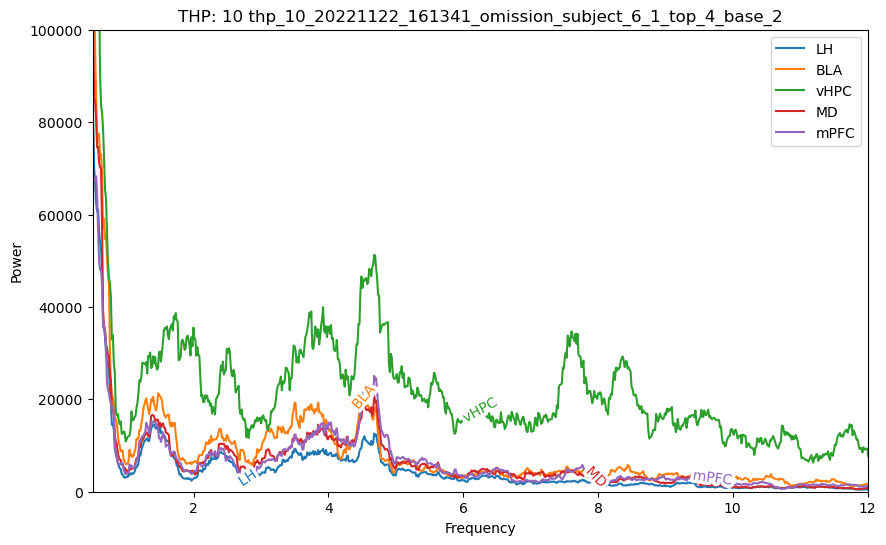

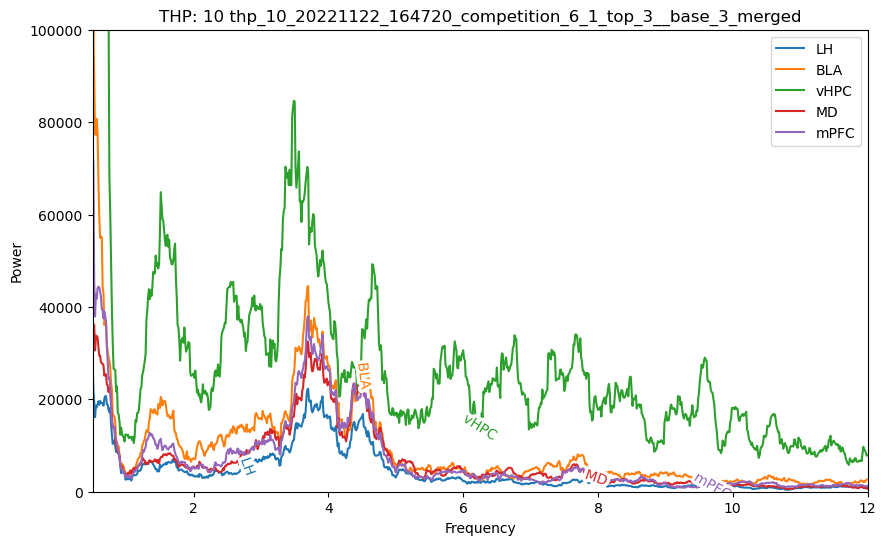

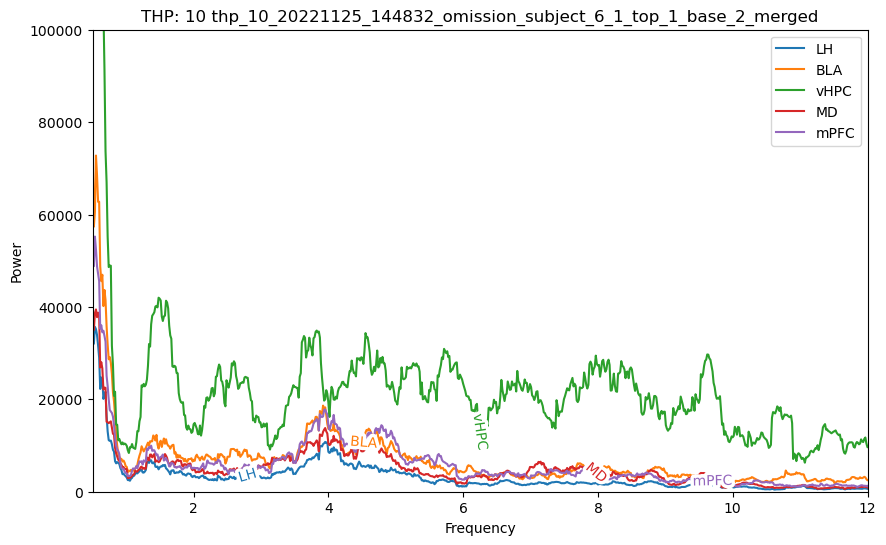

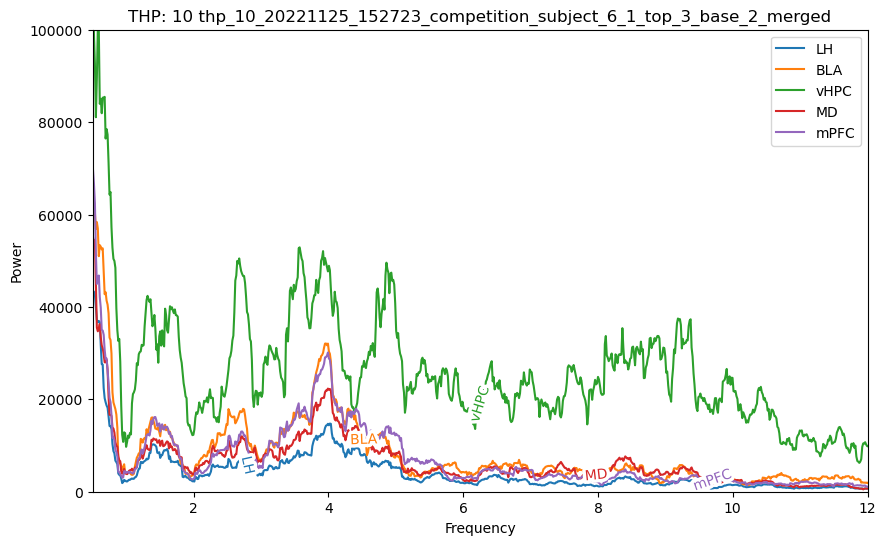

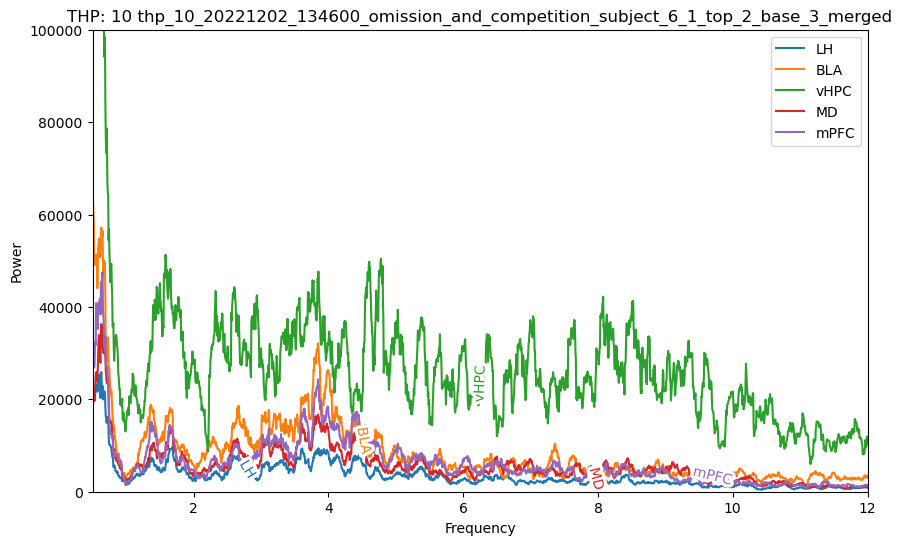

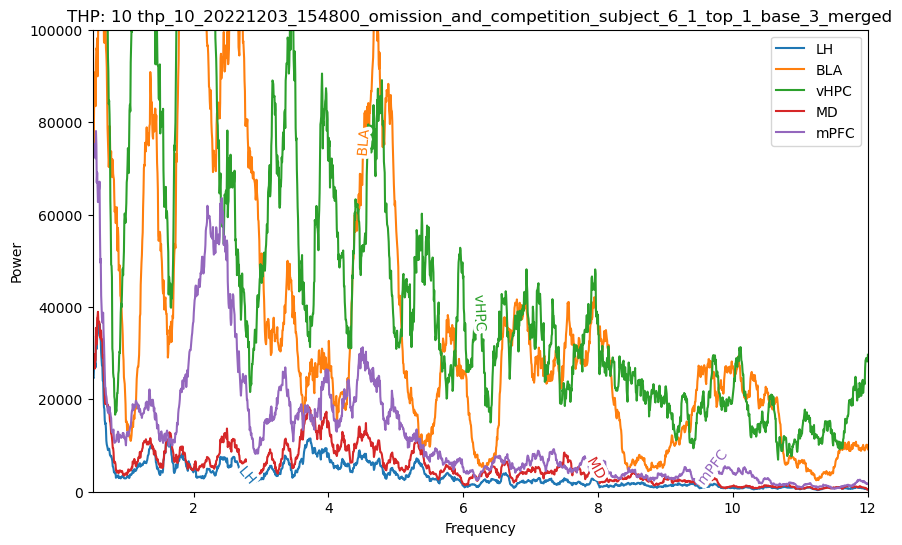

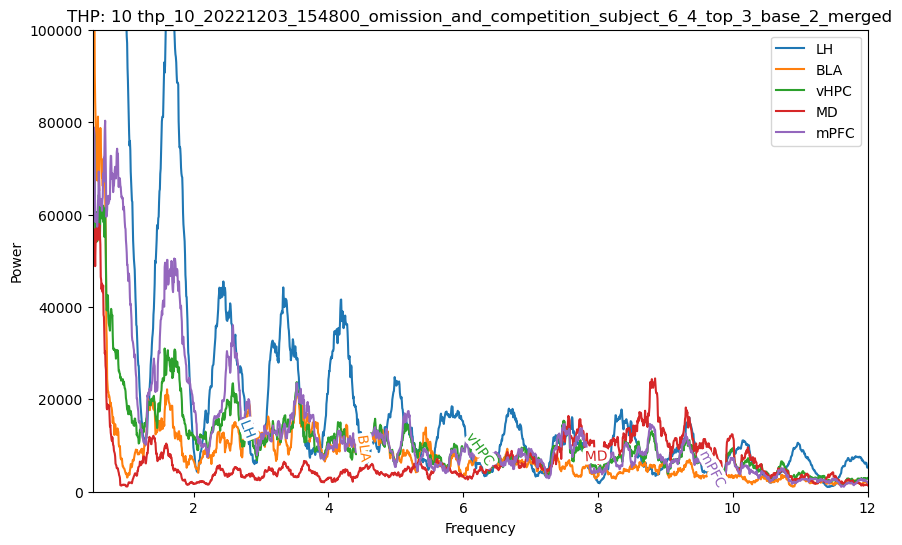

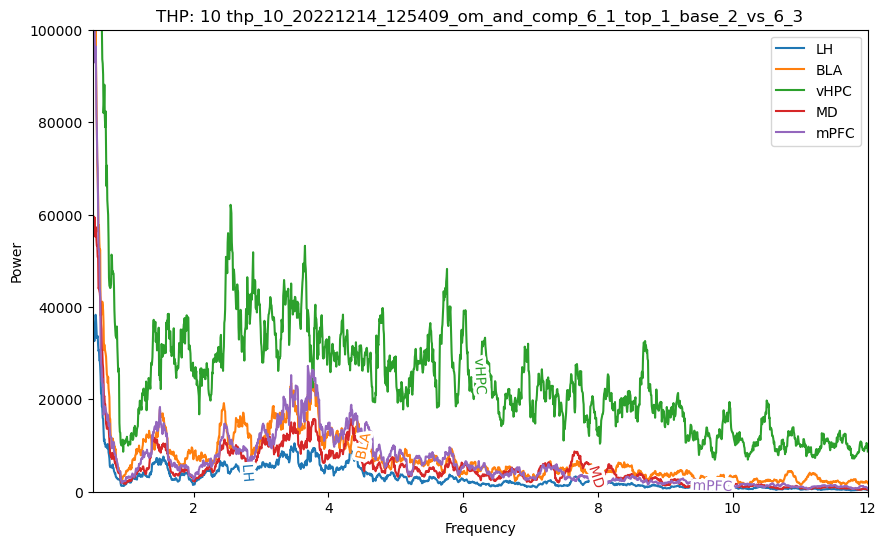

In [50]:
for freq_array_path, power_array_path in zip(freq_array_filepath_glob, power_array_filepath_glob):
    output_dir_path = os.path.dirname(freq_array_path)
    
    freq_array = np.load(freq_array_path)
    power_array = np.load(power_array_path)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")
    ax.plot(freq_array, power_array, label=all_regions)
    
    freq_start = 0.5
    freq_end = 12
    ax.set_xlim(freq_start, freq_end)
    ax.set_ylim(0,100000)
    
    ax.legend()
    labelLines(ax.get_lines(), zorder=2.5)
    
    lfp_basename = os.path.basename(freq_array_path).split(".")[0]
    plt.title("THP: {} {}".format(time_halfbandwidth_product, lfp_basename))
    
    plt_file_name = "freq_{}_{}_{}_{}.png".format(time_halfbandwidth_product, freq_start, freq_end, lfp_basename)
    plt.savefig(os.path.join(output_dir_path, plt_file_name))
    plt.show()

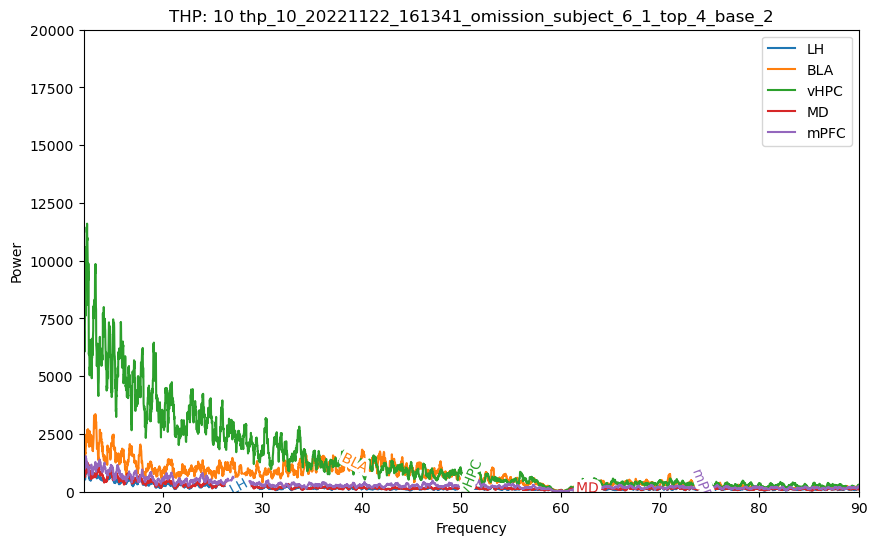

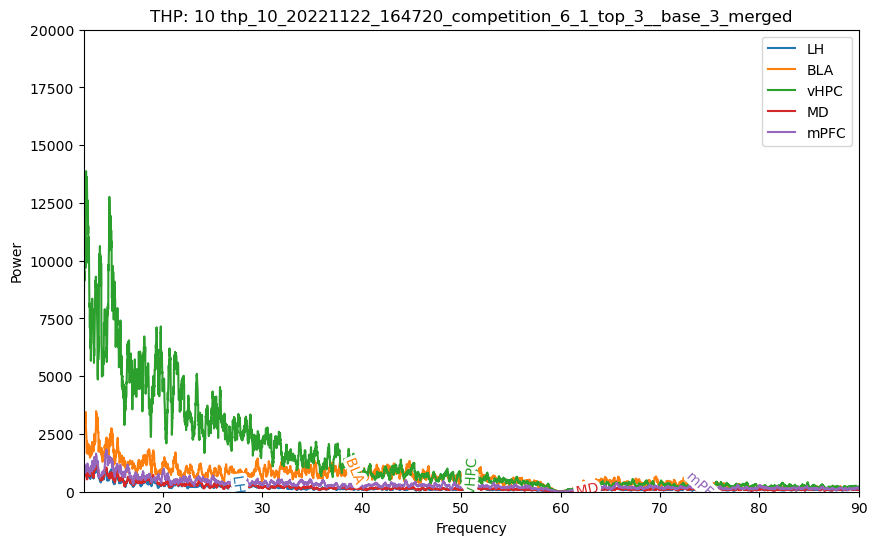

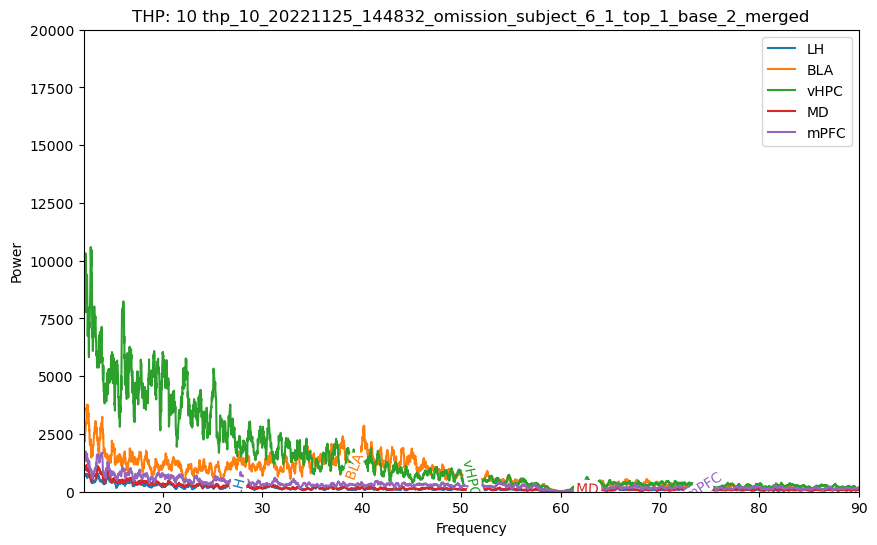

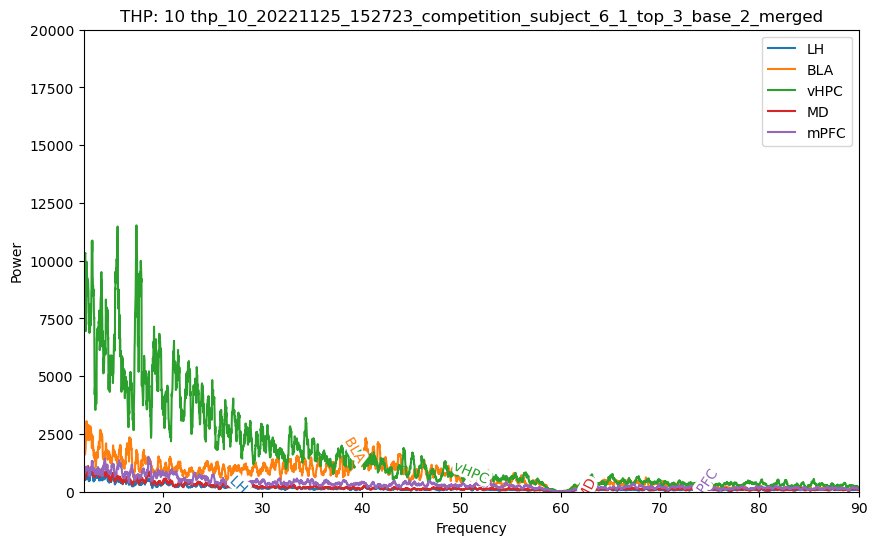

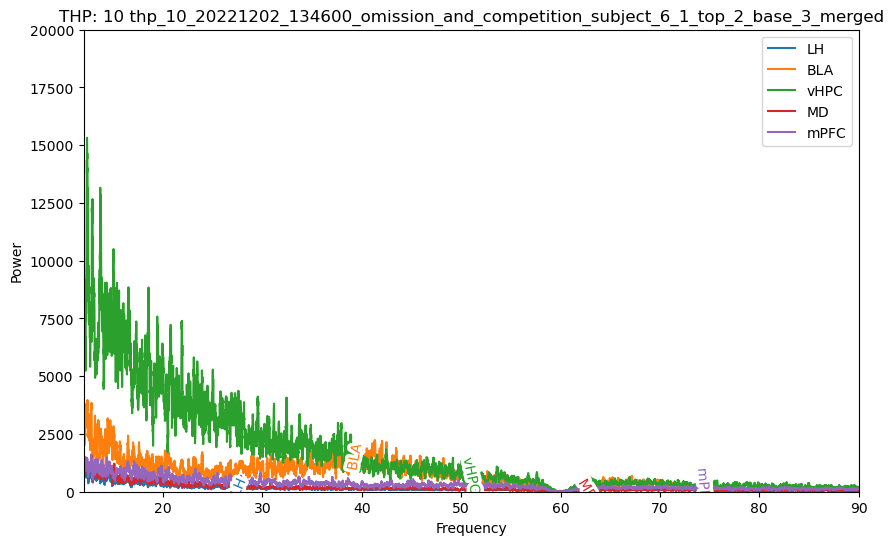

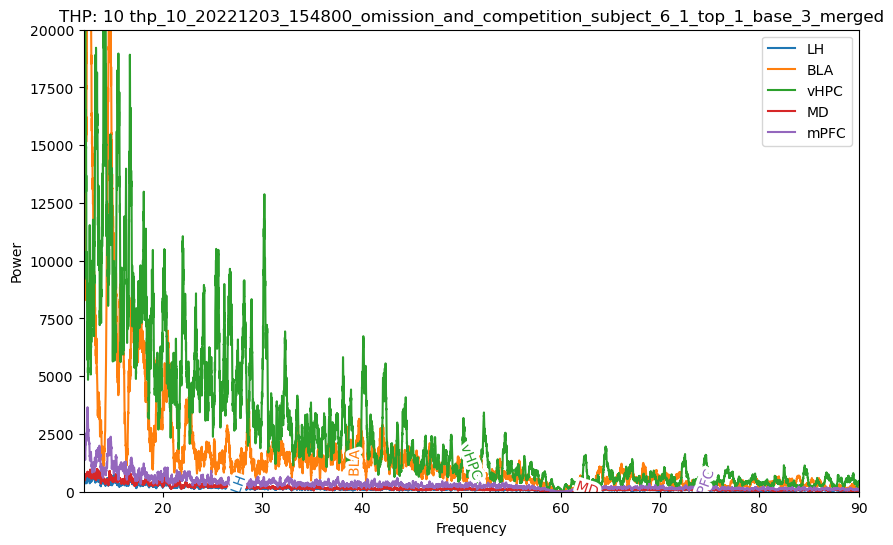

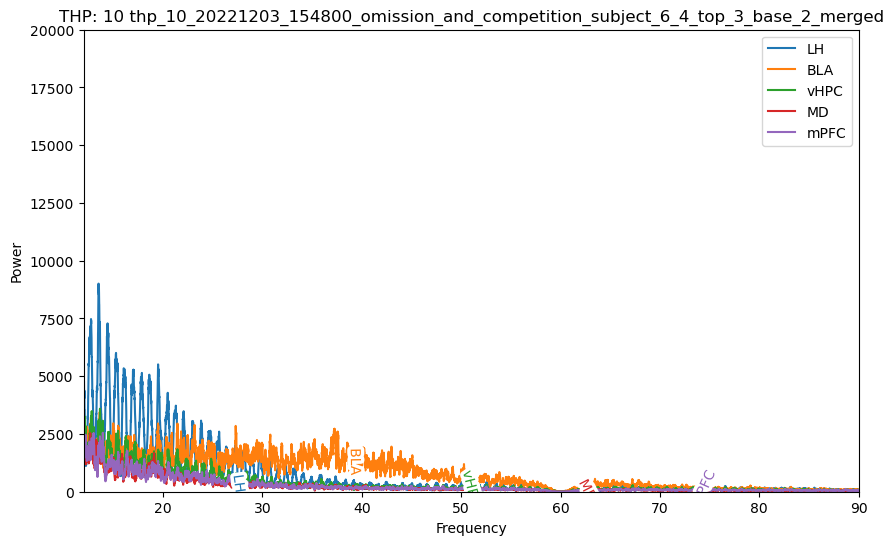

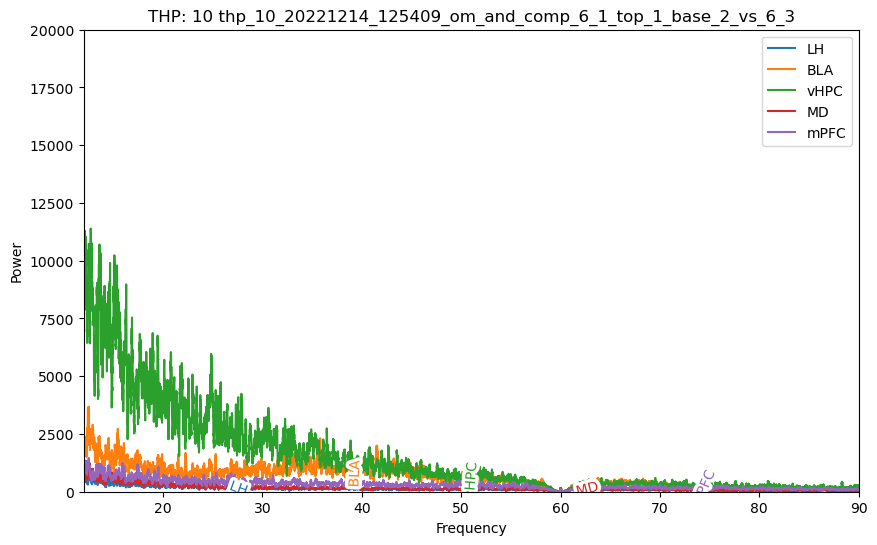

In [51]:
for freq_array_path, power_array_path in zip(freq_array_filepath_glob, power_array_filepath_glob):
    output_dir_path = os.path.dirname(freq_array_path)
    
    freq_array = np.load(freq_array_path)
    power_array = np.load(power_array_path)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")
    ax.plot(freq_array, power_array, label=all_regions)
    
    freq_start = 12
    freq_end = 90
    ax.set_xlim(freq_start, freq_end)
    ax.set_ylim(0,20000)

    ax.legend()
    labelLines(ax.get_lines(), zorder=2.5)
    
    lfp_basename = os.path.basename(freq_array_path).split(".")[0]
    plt.title("THP: {} {}".format(time_halfbandwidth_product, lfp_basename))
    
    plt_file_name = "freq_{}_{}_{}_{}.png".format(time_halfbandwidth_product, freq_start, freq_end, lfp_basename)
    plt.savefig(os.path.join(output_dir_path, plt_file_name))
    plt.show()

## Plotting between regions

In [54]:
[freq_array for freq_array in freq_array_filepath_glob if "20221125" in freq_array]

['./proc/20221125_144832_omission_subject_6_1_top_1_base_2_merged/thp_10_20221125_144832_omission_subject_6_1_top_1_base_2_merged.frequencies.npy',
 './proc/20221125_152723_competition_subject_6_1_top_3_base_2_merged/thp_10_20221125_152723_competition_subject_6_1_top_3_base_2_merged.frequencies.npy']

In [55]:
[power_array for power_array in power_array_filepath_glob if "20221125" in power_array]

['./proc/20221125_144832_omission_subject_6_1_top_1_base_2_merged/thp_10_20221125_144832_omission_subject_6_1_top_1_base_2_merged.power.npy',
 './proc/20221125_152723_competition_subject_6_1_top_3_base_2_merged/thp_10_20221125_152723_competition_subject_6_1_top_3_base_2_merged.power.npy']

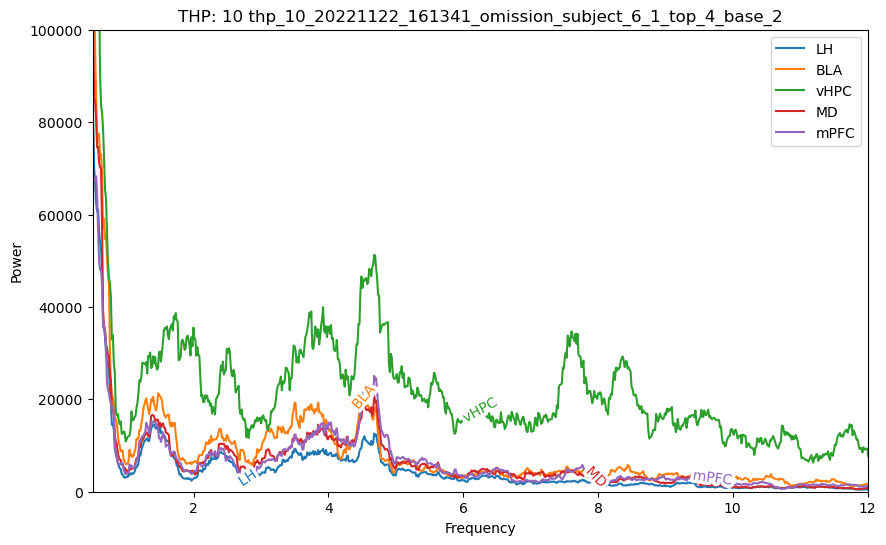

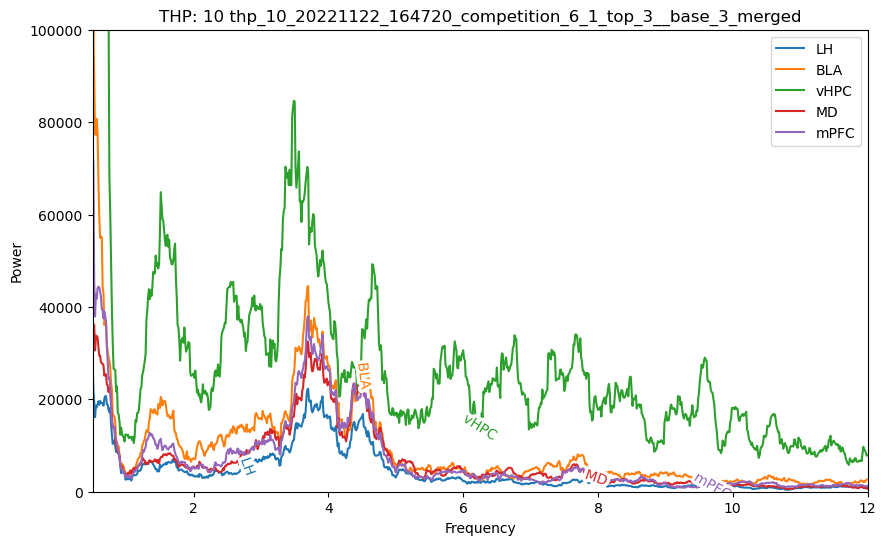

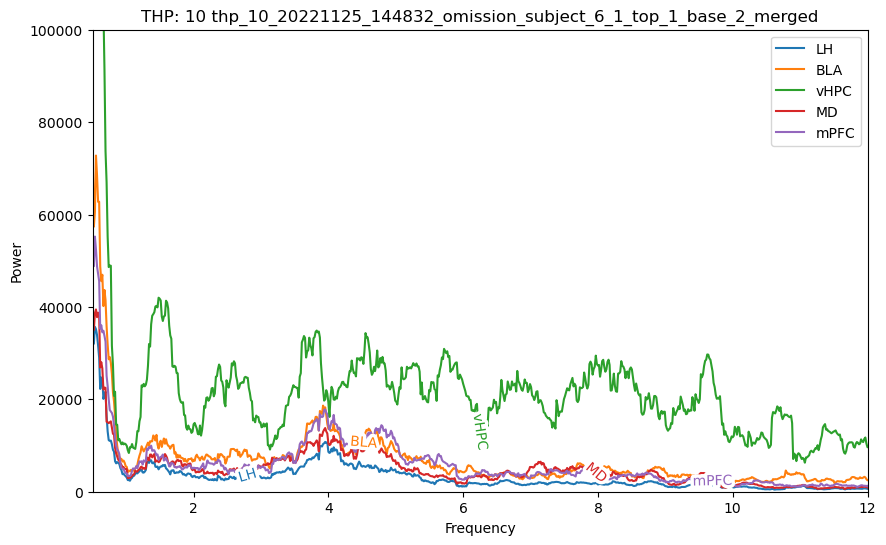

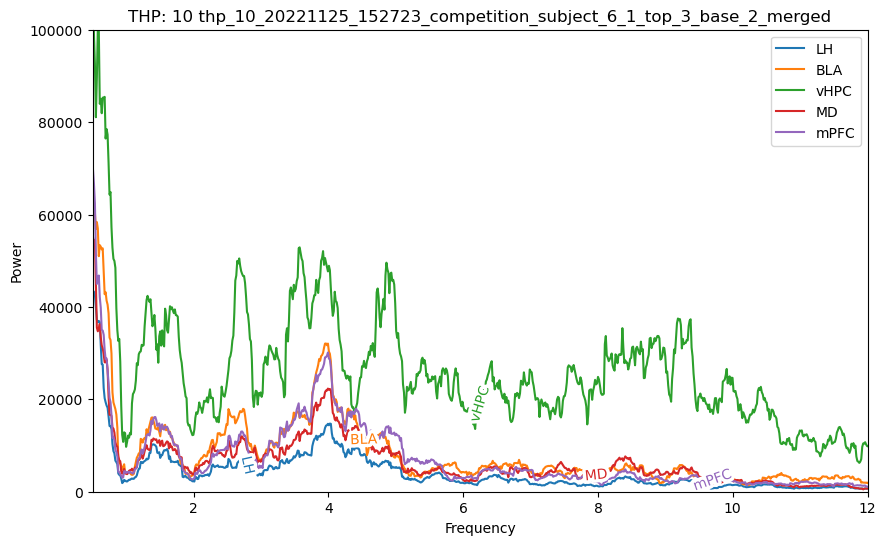

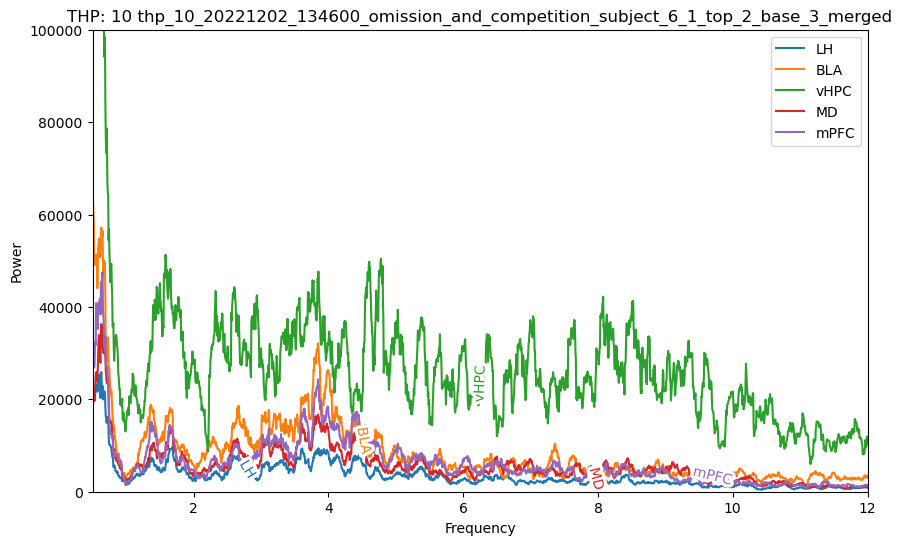

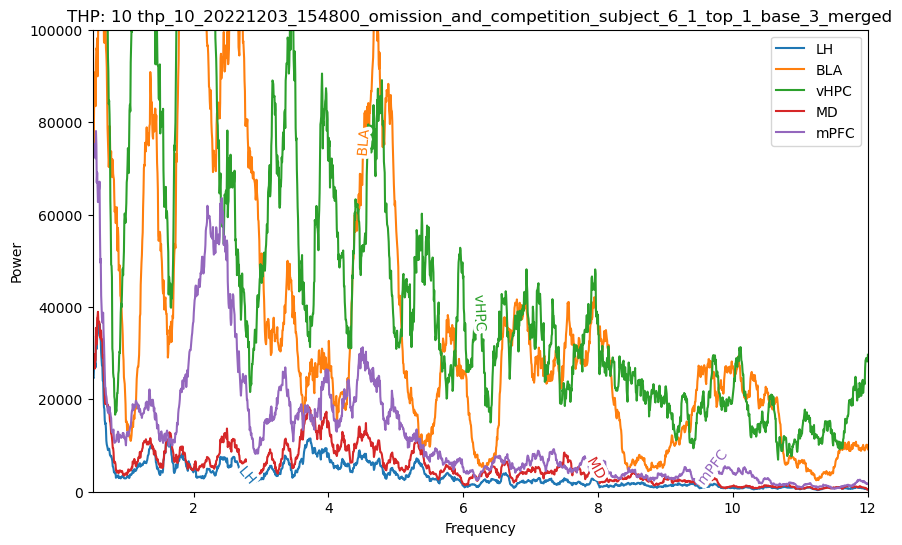

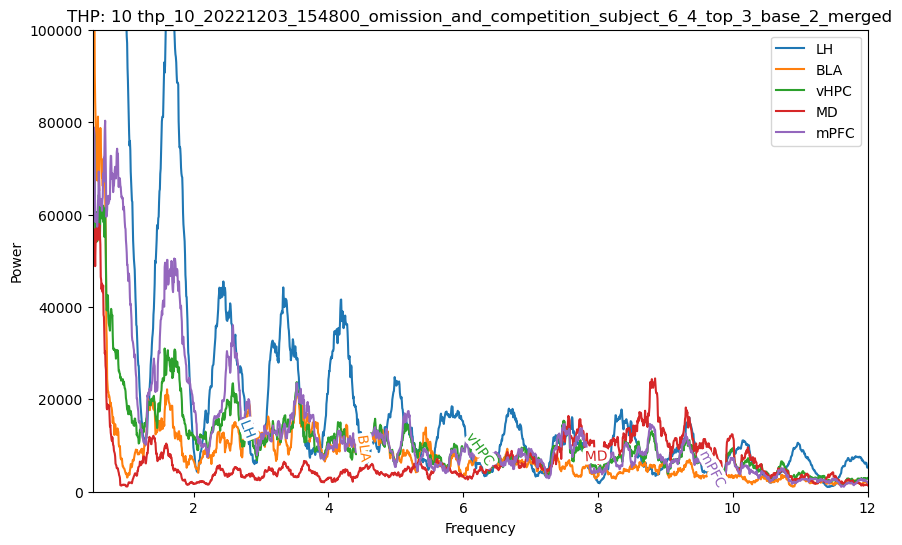

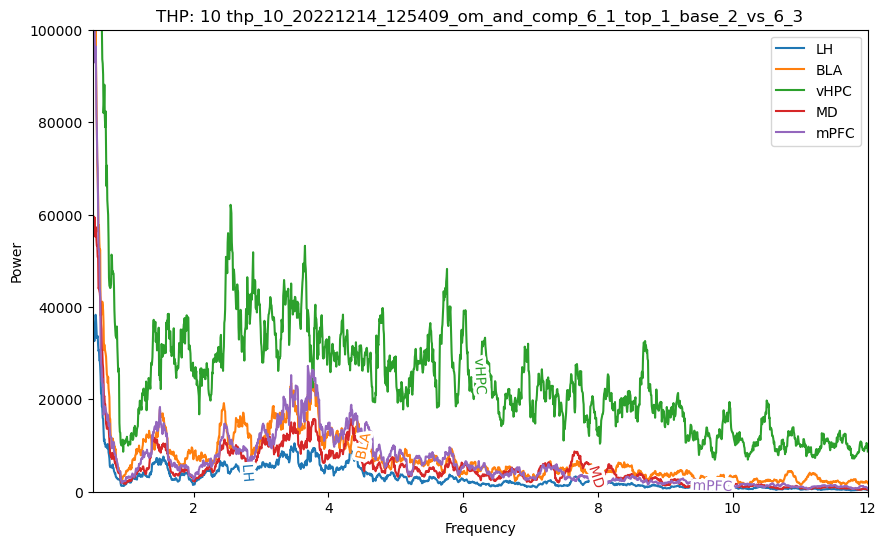

In [52]:
for freq_array_path, power_array_path in zip(freq_array_filepath_glob, power_array_filepath_glob):
    output_dir_path = os.path.dirname(freq_array_path)
    
    freq_array = np.load(freq_array_path)
    power_array = np.load(power_array_path)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")
    ax.plot(freq_array, power_array, label=all_regions)
    
    freq_start = 0.5
    freq_end = 12
    ax.set_xlim(freq_start, freq_end)
    ax.set_ylim(0,100000)
    
    ax.legend()
    labelLines(ax.get_lines(), zorder=2.5)
    
    lfp_basename = os.path.basename(freq_array_path).split(".")[0]
    plt.title("THP: {} {}".format(time_halfbandwidth_product, lfp_basename))
    
    plt_file_name = "freq_{}_{}_{}_{}.png".format(time_halfbandwidth_product, freq_start, freq_end, lfp_basename)
#     plt.savefig(os.path.join(output_dir_path, plt_file_name))
    plt.show()